In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Parámetros
img_size = (224, 224)  # EfficientNet usa 224x224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    r'Datos\Train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    r'Datos\Train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    r'Datos\Test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2369 images belonging to 3 classes.
Found 592 images belonging to 3 classes.
Found 1050 images belonging to 3 classes.


In [4]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size[0], img_size[1], 3)
)
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# intento de clases desbalanceadas
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=[0.25, 0.25, 0.5], gamma=2),
    metrics=['accuracy']
)

In [6]:
# callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# entrenamiento
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping, learning_rate],
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 673ms/step - accuracy: 0.3012 - loss: 0.1652 - val_accuracy: 0.2905 - val_loss: 0.1536 - learning_rate: 1.0000e-04
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 637ms/step - accuracy: 0.2946 - loss: 0.1558 - val_accuracy: 0.2905 - val_loss: 0.1528 - learning_rate: 1.0000e-04
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 47s 633ms/step - accuracy: 0.2977 - loss: 0.1537 - val_accuracy: 0.2905 - val_loss: 0.1547 - learning_rate: 1.0000e-04
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 47s 633ms/step - accuracy: 0.3146 - loss: 0.1558 - val_accuracy: 0.2905 - val_loss: 0.1532 - learning_rate: 1.0000e-04
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 637ms/step - accuracy: 0.2970 - loss: 0.1541 - val_accuracy: 0.2905 - val_loss: 0.1525 - learning_rate: 1.0000e-04
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 634ms/step - accuracy: 0.2905 - loss: 0.1538 - val_accuracy: 0.2905 - val_loss: 0.1533 - learning_rate: 1.0000e-04
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 47s 633ms/step - acc

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - accuracy: 0.0773 - loss: 0.1485

Precisión en test: 33.33%
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 466ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

 Keratoconus       0.00      0.00      0.00       350
      Normal       0.00      0.00      0.00       350
     Suspect       0.33      1.00      0.50       350

    accuracy                           0.33      1050
   macro avg       0.11      0.33      0.17      1050
weighted avg       0.11      0.33      0.17      1050


Matriz de Confusión:


c:\Users\zahid\Escritorio\ProyectoTSBM\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zahid\Escritorio\ProyectoTSBM\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zahid\Escritorio\ProyectoTSBM\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

<Axes: >

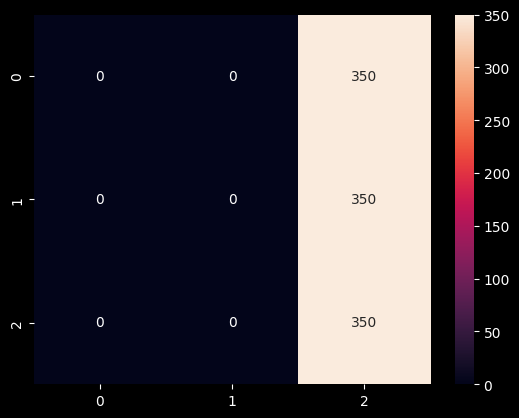

In [7]:
# test
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nPrecisión en test: {test_accuracy * 100:.2f}%")

# Predicciones
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Reporte de clasificación
class_names = list(test_generator.class_indices.keys())
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Matriz de confusión
print("\nMatriz de Confusión:")
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot = True, fmt = 'g')

In [8]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.3526 - loss: 1.1761 - val_accuracy: 0.2905 - val_loss: 1.1283
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4215 - loss: 1.0904 - val_accuracy: 0.2905 - val_loss: 1.1195
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4306 - loss: 1.0521 - val_accuracy: 0.3936 - val_loss: 1.0901
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4797 - loss: 1.0067 - val_accuracy: 0.4003 - val_loss: 1.0857
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4928 - loss: 0.9742 - val_accuracy: 0.4426 - val_loss: 1.0216
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4841 - loss: 0.9686 - val_accuracy: 0.5439 - val_loss: 0.9177
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5215 - loss: 0.9453 - val_accuracy: 0.5726 - val_loss: 0.8770
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4831 - loss: 0.9777 - val_accuracy: 0.5963 - val_loss

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 402ms/step - accuracy: 0.6700 - loss: 0.8482

Precisión en test: 52.00%
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 437ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

 Keratoconus       0.70      0.70      0.70       350
      Normal       0.44      0.80      0.57       350
     Suspect       0.31      0.06      0.10       350

    accuracy                           0.52      1050
   macro avg       0.48      0.52      0.46      1050
weighted avg       0.48      0.52      0.46      1050


Matriz de Confusión:


<Axes: >

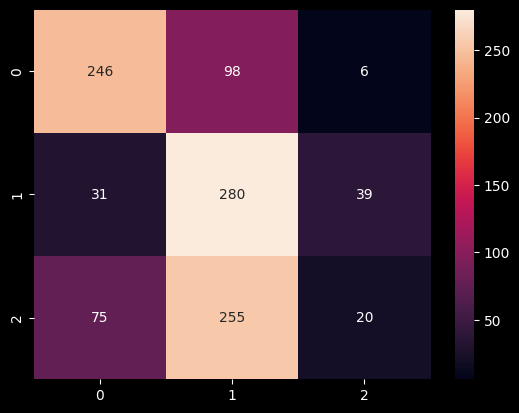

In [10]:
# test
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nPrecisión en test: {test_accuracy * 100:.2f}%")

# Predicciones
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Reporte de clasificación
class_names = list(test_generator.class_indices.keys())
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Matriz de confusión
print("\nMatriz de Confusión:")
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot = True, fmt = 'g')

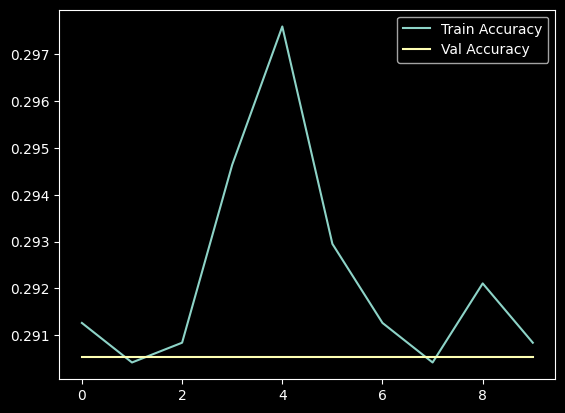

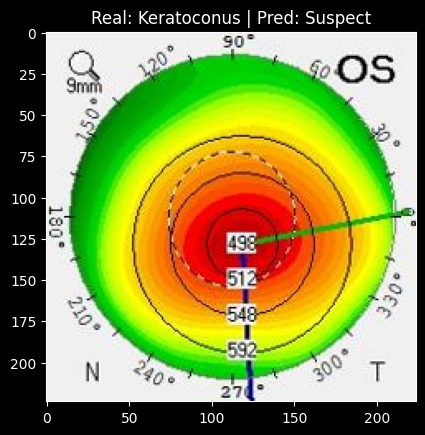

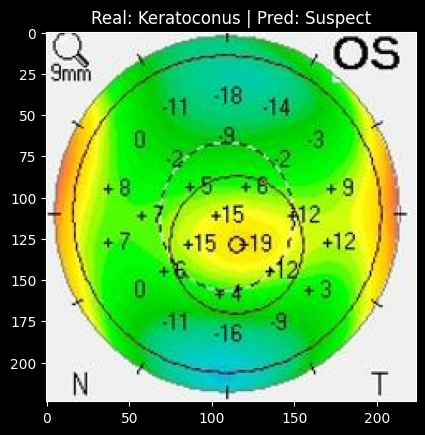

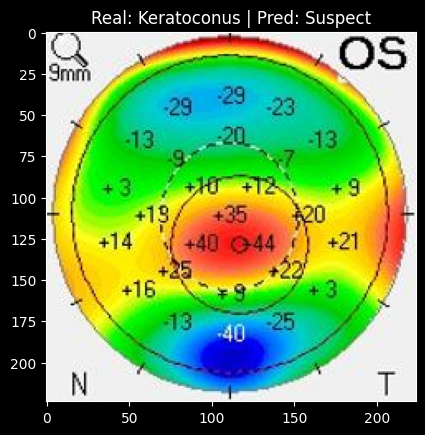

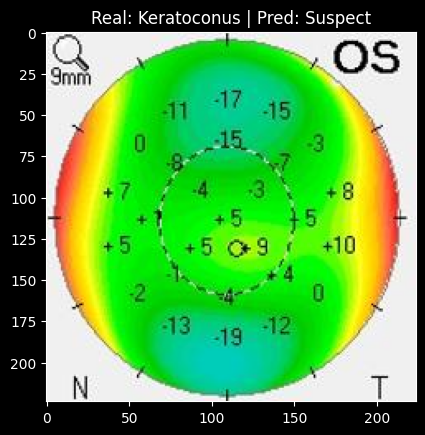

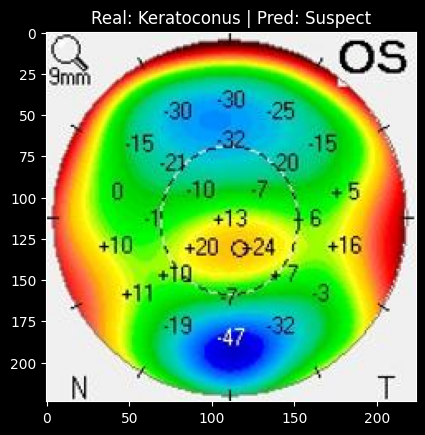

In [9]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

# imágenes mal clasificadas
errors = np.where(y_pred_classes != y_true)[0]
for i in errors[:5]:
    img_path = os.path.join(r'Datos\Test', test_generator.filenames[i])
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f'Real: {class_names[y_true[i]]} | Pred: {class_names[y_pred_classes[i]]}')
    plt.show()